In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt

In [3]:
from pandas_datareader import data as data #import pandas datareader
import yfinance as yf 
#override the data reader function
yf.pdr_override()
df = data.get_data_yahoo("AAPL", start="2012-01-01", end="2022-12-31") # I got results for TSLA but you can change whatever you like

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466097,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533090,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672230,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804706,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784390,394024400


In [5]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466097,302220800
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533090,260022000
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672230,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804706,318292800
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784390,394024400


In [6]:
# dont need date and adj close column so dropping
df= df.drop(['Adj Close','Date'], axis =1)
df.head()

,Open,High,Low,Close,Volume
0,14.621429,14.732143,14.607143,14.686786,302220800
1,14.642857,14.810000,14.617143,14.765714,260022000
2,14.819643,14.948214,14.738214,14.929643,271269600
3,14.991786,15.098214,14.972143,15.085714,318292800
4,15.196429,15.276786,15.048214,15.061786,394024400


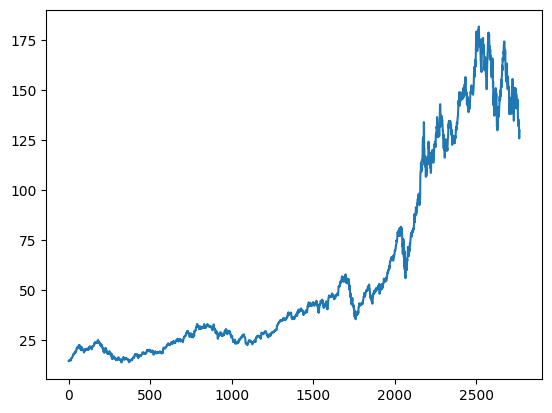

In [7]:
plt.plot(df.Close)

In [8]:
# we want to calculate 100 Moving average for that we will apply rolling function on Close column because we are doing analysis on Close column
ma100 = df.Close.rolling(100).mean()
ma100

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
2763    150.515600
2764    150.157800
2765    149.764699
2766    149.412100
2767    149.062199
Name: Close, Length: 2768, dtype: float64

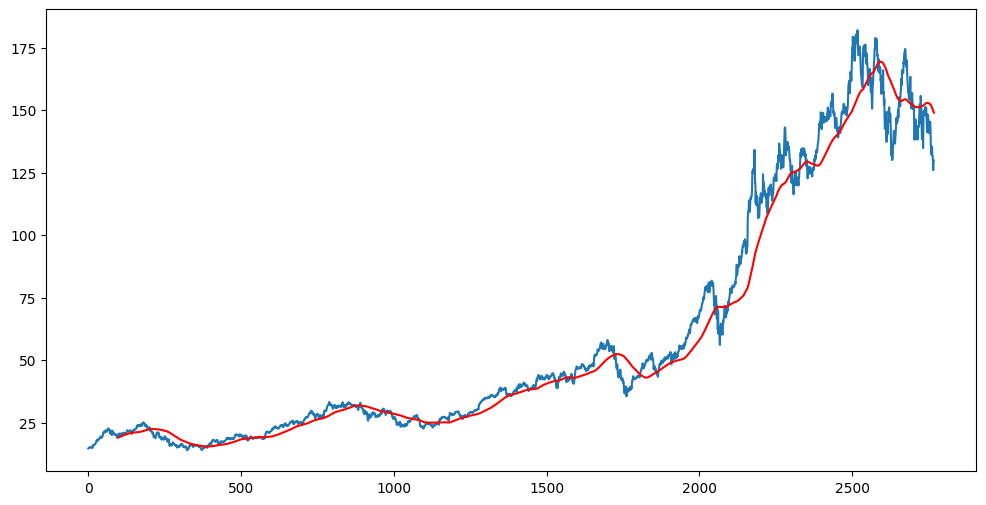

In [9]:
plt.figure(figsize =(12,6))
plt.plot(df.Close)
plt.plot(ma100,'r') # for red color

In [10]:
ma200 = df.Close.rolling(200).mean()
ma200

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
2763    152.1331
2764    152.0096
2765    151.8867
2766    151.7593
2767    151.6110
Name: Close, Length: 2768, dtype: float64

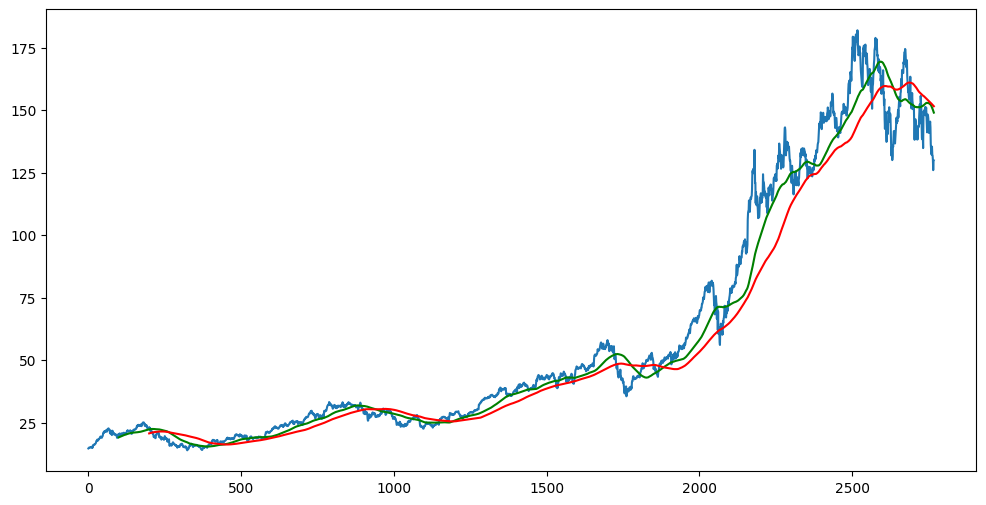

In [11]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'g')
plt.plot(ma200,'r')

In [12]:
df.shape

(2768, 5)

## Split data into Training and Testing

In [13]:
data_training = pd.DataFrame(df['Close'][0: int(len(df)*0.70)])        
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70): int(len(df))])
print(data_training.shape)
print(data_testing.shape)

(1937, 1)
(831, 1)


In [14]:
data_training.head()

,Close
0,14.686786
1,14.765714
2,14.929643
3,15.085714
4,15.061786


In [15]:
data_testing.head()

,Close
1937,54.974998
1938,55.174999
1939,55.692501
1940,55.240002
1941,54.432499


In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [17]:
data_training_array= scaler.fit_transform(data_training)
data_training_array

array([[0.01677525],
       [0.01856622],
       [0.02228596],
       ...,
       [0.95189465],
       [0.94905826],
       [0.92443835]])

In [19]:
data_training_array.shape

(1937, 1)

In [20]:
x_train= []
y_train= []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i,0])

# x_train
x_train, y_train = np.array(x_train), np.array(y_train)


In [21]:
x_train.shape

(1837, 100, 1)

In [23]:
from keras.layers import Dense,Dropout, LSTM
from keras.models import Sequential

In [24]:
model = Sequential()
model.add(LSTM(units= 50,activation= 'relu', return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units= 60,activation= 'relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units= 80,activation= 'relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units= 120,activation= 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [26]:
model.compile(optimizer ='adam', loss='mean_squared_error')
model.fit(x_train,y_train,epochs=50)

Epoch 1/50
58/58 [==============================] - 35s 435ms/step - loss: 0.0437
Epoch 2/50
58/58 [==============================] - 21s 357ms/step - loss: 0.0087
Epoch 3/50
58/58 [==============================] - 26s 444ms/step - loss: 0.0079
Epoch 4/50
58/58 [==============================] - 27s 473ms/step - loss: 0.0072
Epoch 5/50
58/58 [==============================] - 26s 453ms/step - loss: 0.0068
Epoch 6/50
58/58 [==============================] - 28s 483ms/step - loss: 0.0069
Epoch 7/50
58/58 [==============================] - 24s 408ms/step - loss: 0.0066
Epoch 8/50
58/58 [==============================] - 25s 435ms/step - loss: 0.0064
Epoch 9/50
58/58 [==============================] - 29s 496ms/step - loss: 0.0054
Epoch 10/50
58/58 [==============================] - 26s 442ms/step - loss: 0.0053
Epoch 11/50
58/58 [==============================] - 29s 504ms/step - loss: 0.0050
Epoch 12/50
58/58 [==============================] - 24s 406ms/step - loss: 0.0053
Epoch 13/50
5

In [27]:
model.save('my_model.keras')

In [28]:
data_testing.head()

,Close
1937,54.974998
1938,55.174999
1939,55.692501
1940,55.240002
1941,54.432499


In [29]:
data_testing.shape

(831, 1)

In [30]:
data_training.tail(100)

,Close
1837,51.790001
1838,51.320000
1839,51.075001
1840,51.152500
1841,50.167500
...,...
1932,53.542500
1933,54.174999
1934,55.897499
1935,55.772499


In [31]:
# append past 100 days data for testing data.
past_100_days = data_training.tail(100)

In [32]:
# final_df= past_100_days.append(data_testing,ignore_index=True)
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)

In [33]:
final_df.head()

,Close
0,51.790001
1,51.320000
2,51.075001
3,51.152500
4,50.167500


In [34]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.06103761],
       [0.05764862],
       [0.05588204],
       [0.05644085],
       [0.04933842],
       [0.0670945 ],
       [0.06462486],
       [0.06931175],
       [0.06341709],
       [0.05328622],
       [0.05335832],
       [0.04942856],
       [0.04304718],
       [0.02238886],
       [0.02768865],
       [0.03176262],
       [0.0302484 ],
       [0.02830154],
       [0.0176479 ],
       [0.0239752 ],
       [0.01708908],
       [0.01146483],
       [0.010221  ],
       [0.00888703],
       [0.0073548 ],
       [0.00901323],
       [0.00319069],
       [0.        ],
       [0.01142877],
       [0.01665643],
       [0.02148754],
       [0.03037457],
       [0.03475502],
       [0.03877491],
       [0.03765728],
       [0.03758516],
       [0.03504345],
       [0.03711648],
       [0.04533655],
       [0.04429101],
       [0.04715724],
       [0.04593142],
       [0.0455709 ],
       [0.04014494],
       [0.04777013],
       [0.04766197],
       [0.04438114],
       [0.050

In [35]:
input_data.shape

(931, 1)

In [36]:
x_test =[]
y_test =[]

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i,0])
 

In [37]:
x_test,y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(831, 100, 1)
(831,)


In [38]:
y_predicted = model.predict(x_test)

26/26 [==============================] - 7s 205ms/step


In [39]:
y_predicted.shape

(831, 1)

In [40]:
y_test

array([0.0840033 , 0.08544543, 0.08917692, 0.08591413, 0.08009156,
       0.08187619, 0.08000143, 0.0860403 , 0.08398529, 0.08205647,
       0.09134009, 0.09245772, 0.08230884, 0.08566176, 0.09682012,
       0.09691026, 0.09211521, 0.09685618, 0.10237228, 0.11340449,
       0.11279157, 0.11180014, 0.1100876 , 0.11172801, 0.11376501,
       0.12115585, 0.12016441, 0.12596891, 0.12668998, 0.13209792,
       0.13655046, 0.1261672 , 0.12611312, 0.13602768, 0.14875439,
       0.15178282, 0.15111585, 0.15131411, 0.15526191, 0.15654183,
       0.16025528, 0.15982261, 0.16434727, 0.16104845, 0.1666727 ,
       0.16908823, 0.1676281 , 0.16203988, 0.15991277, 0.15949814,
       0.16777228, 0.1640228 , 0.17042218, 0.16935862, 0.16378845,
       0.155298  , 0.15942602, 0.16634818, 0.17559576, 0.16876377,
       0.1715759 , 0.17570392, 0.17694775, 0.18359952, 0.19208996,
       0.19308145, 0.19187366, 0.19237839, 0.19133288, 0.19955295,
       0.20003964, 0.21020659, 0.21000827, 0.21310883, 0.21694

In [41]:
y_predicted

array([[0.10466631],
       [0.10653023],
       [0.10838506],
       [0.11016402],
       [0.11179078],
       [0.11314146],
       [0.11414674],
       [0.11477517],
       [0.11510694],
       [0.11522835],
       [0.11519511],
       [0.11515331],
       [0.11523646],
       [0.11540475],
       [0.11561383],
       [0.11594921],
       [0.11648418],
       [0.11718608],
       [0.1180357 ],
       [0.11906151],
       [0.12038757],
       [0.12207383],
       [0.1240828 ],
       [0.12629503],
       [0.12858182],
       [0.13084182],
       [0.13307443],
       [0.1352702 ],
       [0.1374694 ],
       [0.13968226],
       [0.14196178],
       [0.14437574],
       [0.14678967],
       [0.14905272],
       [0.15115717],
       [0.1532786 ],
       [0.1556    ],
       [0.15819657],
       [0.16104004],
       [0.16409867],
       [0.16730785],
       [0.17060678],
       [0.17391764],
       [0.17719547],
       [0.18035492],
       [0.18337108],
       [0.18624702],
       [0.188

In [42]:
scaler.scale_

array([0.00721059])

In [43]:
scale_factor=1/0.00721059
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

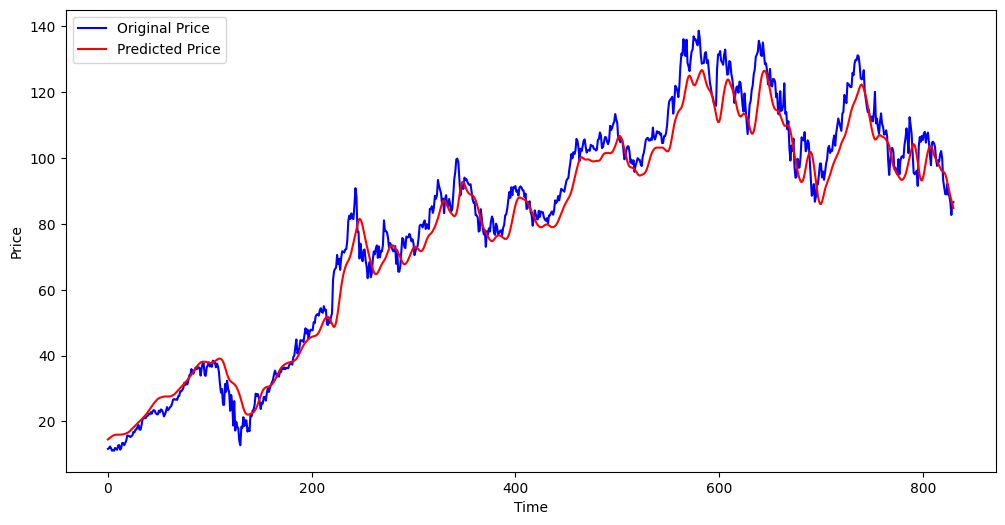

In [50]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label = 'Original Price')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()